<a href="https://colab.research.google.com/github/tmohammad78/deep-learning-projects/blob/feature%2Focr_captcha/ocr_captcha/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
!curl -LO https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
!unzip -qq captcha_images_v2.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   159  100   159    0     0    326      0 --:--:-- --:--:-- --:--:--   326
100 8863k  100 8863k    0     0  6450k      0  0:00:01  0:00:01 --:--:-- 26.1M


In [3]:
data_dir = Path("./captcha_images_v2")
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
# lables = []
# for img in images:
#   lables.append(img.split(os.path.sep)[-1].split(".png")[0])
# lables
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)
# for label in labels:
#   for char in label:
#     print(char)
batch_size = 16

# Desired image dimensions
img_width = 200
img_height = 50

In [4]:
print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

Number of images found:  1040
Number of labels found:  1040
Number of unique characters:  19
Characters present:  {'5', '3', 'm', 'c', 'e', 'x', 'g', '7', '8', '4', 'p', 'd', 'w', 'f', 'y', 'b', 'n', '6', '2'}


In [5]:
char_to_num = layers.experimental.preprocessing.StringLookup(vocabulary=list(characters),mask_token=None)

num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


In [6]:
def split_data(images,labels,train_size=0.9,shuffle=True):
  size = len(images)
  indices = np.arange(size)
  data_size = int(size * train_size)
  if shuffle:
    np.random.shuffle(indices)
  x_train , y_train = images[indices[:data_size]] , labels[indices[:data_size]] 
  x_test , y_test = images[indices[:data_size]] , labels[indices[:data_size]] 
  return x_train,x_test,y_train,y_test


In [7]:
x_train,x_test,y_train,y_test = split_data(np.array(images),np.array(labels))

In [8]:
def encode(image_path,label):
  image = tf.io.read_file(image_path)

  image = tf.io.decode_png(image,channels=1)

  image = tf.image.convert_image_dtype(image,tf.float32)

  image = tf.image.resize(image,[img_height,img_width])
  image = tf.transpose(image,perm=[1,0,2])
  # https://www.tensorflow.org/api_docs/python/tf/transpose
  label = char_to_num(tf.strings.unicode_split(label,input_encoding="UTF-8"))
  return {"image": image, "label": label}

In [9]:

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
validation_dataset = (
    validation_dataset.map(
        encode, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

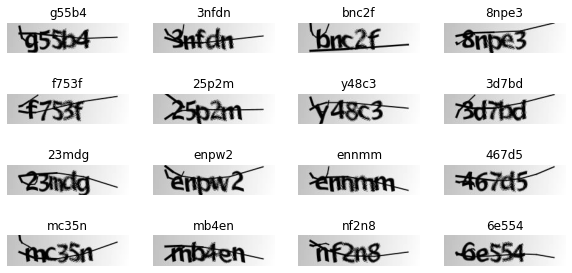

In [10]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [11]:
def cnn_model(inputs):
  x = layers.Conv2D(32,(3,3),activation="relu",padding="same",name="Conv1")(inputs)
  x = layers.MaxPooling2D((2,2),name="pool1")(x)

  x = layers.Conv2D(64,(3,3),activation="relu",padding="same",name="Conv2")(x)
  x = layers.MaxPooling2D((2,2),name="pool2")(x)
  
  return x


In [12]:
class CTCLayer(layers.Layer):
  def __init__(self,name=None):
    super().__init__(name=name)
    self.loss_fn = keras.backend.ctc_batch_cost
  def call(self, y_true, y_pred):
    # Compute the training-time loss value and add it
    # to the layer using `self.add_loss()`.
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = self.loss_fn(y_true, y_pred, input_length, label_length)
    self.add_loss(loss)

    # At test time, just return the computed predictions
    return y_pred

In [13]:
def reshape(input,new_shape):
  x = layers.Reshape(target_shape=new_shape, name="reshape")(input)
  x = layers.Dense(64, activation="relu", name="dense1")(x)
  x = layers.Dropout(0.2)(x)
  return x

In [14]:
def rnn_model(x):
  x = layers.Bidirectional(layers.LSTM(128,return_sequences=True,dropout=0.25))(x)
  x = layers.Bidirectional(layers.LSTM(64,return_sequences=True,dropout=0.25))(x)
  return x

In [15]:
def outputLayer(input_image):
  new_shape = ((img_width //4 ),(img_height // 4) * 64)
  cnn_output = cnn_model(input_image)
  
  reshape_output = reshape(cnn_output,new_shape)
  rnn_output = rnn_model(reshape_output)
  
  x = layers.Dense(len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2")(rnn_output)

  return x

In [16]:
def build_model():
  input_shape = (img_width,img_height,1)
  input_image = layers.Input(shape=input_shape,name="image",dtype="float32")
  labels = layers.Input(name="label", shape=(None,), dtype="float32")

  # outout layer
  x = outputLayer(input_image)
  # loss 
  output = CTCLayer(name="ctc_loss")(labels, x)
  #model
  model = keras.models.Model(
      inputs=[input_image, labels], outputs=output, name="ocr_model_v1"
  )
  # Optimizer
  opt = keras.optimizers.Adam()
  # Compile the model and return
  model.compile(optimizer=opt)
  return model

In [17]:
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 200, 50, 1)] 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 200, 50, 32)  320         image[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 100, 25, 32)  0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 100, 25, 64)  18496       pool1[0][0]                      
_______________________________________________________________________________________

In [18]:
epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/100
59/59 [==============================] - 36s 487ms/step - loss: 22.8052 - val_loss: 16.3442
Epoch 2/100
59/59 [==============================] - 27s 460ms/step - loss: 16.3592 - val_loss: 16.3269
Epoch 3/100
59/59 [==============================] - 27s 454ms/step - loss: 16.3438 - val_loss: 16.3233
Epoch 4/100
59/59 [==============================] - 27s 452ms/step - loss: 16.3425 - val_loss: 16.3172
Epoch 5/100
59/59 [==============================] - 27s 458ms/step - loss: 16.3332 - val_loss: 16.3085
Epoch 6/100
59/59 [==============================] - 27s 454ms/step - loss: 16.3277 - val_loss: 16.3067
Epoch 7/100
59/59 [==============================] - 27s 466ms/step - loss: 16.3212 - val_loss: 16.2935
Epoch 8/100
59/59 [==============================] - 27s 463ms/step - loss: 16.3157 - val_loss: 16.2843
Epoch 9/100
59/59 [==============================] - 27s 459ms/step - loss: 16.2984 - val_loss: 16.2637
Epoch 10/100
59/59 [==============================] - 27s 463ms/

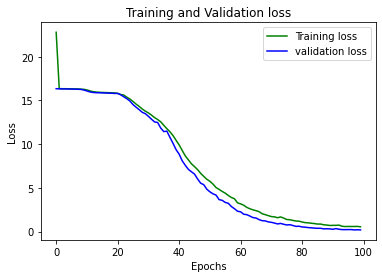

In [19]:
training = history.history['loss']
validation = history.history['val_loss']
plt.plot(training, 'g', label='Training loss')
plt.plot(validation, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

(100,)